# Sen12MS EDA 



Author: Ernesto Oropeza

In [2]:
! pip install geopandas
! pip install contextily 

In [3]:
import pandas as pd
import os, glob
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx
import rasterio
import numpy as np
from pyproj import Proj, transform

import warnings
warnings.filterwarnings('ignore')

root = "/storage/sen12ms_x"

In [4]:
# os.listdir(os.path.join(root,'ROIs2017_winter/lc_75'))
os.listdir(os.path.join(root))

['ROIs1970_fall', 'ROIs2017_winter', 'ROIs1868_summer', 'ROIs1158_spring']

## Iterate through files

## Get region location

In [5]:
def get_xy(path):
    with rasterio.open(path, 'r') as src:
        trafo = src.transform
        crs = src.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)

    return x,y

# regions = lc.groupby("region").first()
# xy = pd.DataFrame.from_records(regions["path"].apply(get_xy), columns=["x","y"])
# regions = regions.reset_index().join(xy)

## Plot region location

In [6]:
# gdf = gpd.GeoDataFrame(regions, geometry=gpd.points_from_xy(regions.y, regions.x),crs=4326).to_crs(epsg=3857)

# fig,ax=plt.subplots(figsize=(15,16))
# gdf.plot(ax=ax,column="season",legend=True)
# # ax.scatter(gdf.geometry.x,gdf.geometry.y, c=gdf.season)
# ctx.add_basemap(ax, url=ctx.providers.Stamen.TerrainBackground,zoom=1)

# for x,y,region in zip(gdf.geometry.x,gdf.geometry.y,gdf.region):
#     ax.annotate(region,(x,y))

# ax.set_xlim(-20026376.39,20026376.39)
# ax.set_ylim(-1e7, 1.5e7)
# ax.axis('off')

## Save shapefile

In [7]:
# gdf.to_file("regions.shp")

### Full Labels

In [5]:
class_full = [
    "Evergreen Needleleaf Forests",
    "Evergreen Broadleaf Forests",
    "Deciduous Needleleaf Forests",
    "Deciduous Broadleaf Forests",
    "Mixed Forests",
    "Closed (Dense) Shrublands",
    "Open (Sparse) Shrublands",
    "Woody Savannas",
    "Savannas",
    "Grasslands",
    "Permanent Wetlands",
    "Croplands",
    "Cropland/Natural Vegetation Mosaics",
    "Urban and Built-Up Lands",
    "Permanent Snow and Ice",
    "Barren",
    "Water Bodies"
]

class_simp = ['Forest', 'Shrublands', 'Savana', 'Grassland', 'Wetlands',
              'Croplands', 'Urban and Built-Up Lands','Permanent Snow and Ice','Barren','Water Bodies'
]

cf_dict = {}
cs_dict = {}
for i in range(len(class_full)):
    cf_dict[class_full[i]] = i+1
    
for i in range(len(class_simp)):
    cs_dict[class_simp[i]] = i+1

In [6]:
cf_df = pd.DataFrame(list(cf_dict.items()),columns = ['Full Lable','lfidex']) 
cs_df = pd.DataFrame(list(cs_dict.items()),columns = ['Simple Lable','lsidex']) 

In [7]:
cs_df

,Simple Lable,lsidex
0,Forest,1
1,Shrublands,2
2,Savana,3
3,Grassland,4
4,Wetlands,5
5,Croplands,6
6,Urban and Built-Up Lands,7
7,Permanent Snow and Ice,8
8,Barren,9
9,Water Bodies,10


In [8]:
import pandas as pd
full_labels = pd.read_csv('/scratch/crguest/SEN12MS/labels/single_label_IGBPfull_ClsNum.txt', delimiter = ":",header=None)
full_labels.columns=['Patch','lfidex']
simp_labels = pd.read_csv('/scratch/crguest/SEN12MS/labels/single_label_IGBPsimple_ClsNum.txt', delimiter = ":",header=None)
simp_labels.columns=['Patch','lsidex']

In [9]:
both_labels = pd.merge(full_labels,simp_labels,on='Patch',how='right')

In [10]:
dfinal = both_labels.merge(cf_df, on="lfidex", how = 'outer').copy()
dfinal = dfinal.merge(cs_df, on="lsidex", how = 'outer').copy()

In [11]:
tiles = pd.DataFrame(glob.glob(os.path.join(root,'*','*','*.tif')), columns=["path"])
split = tiles["path"].apply(lambda path: os.path.basename(path).split('_'))
split = pd.DataFrame.from_records(split, columns=["seed","season","sensor","region","tile"])
tiles = tiles.join(split)

In [12]:
split.head()

,seed,season,sensor,region,tile
0,ROIs1970,fall,s1,149,p404.tif
1,ROIs1970,fall,s1,149,p798.tif
2,ROIs1970,fall,s1,149,p810.tif
3,ROIs1970,fall,s1,149,p186.tif
4,ROIs1970,fall,s1,149,p510.tif


In [13]:
dfsplit= dfinal['Patch'].apply(lambda x: str(x)[:-4].split('_'))
dfsplit = pd.DataFrame.from_records(dfsplit, columns=["seed","season","sensor","region","tile"])
dfinal = dfinal.join(dfsplit)

In [156]:
dfinal.head()

,Patch,lfidex,lsidex,Full Lable,Simple Lable,seed,season,sensor,region,tile
0,ROIs1158_spring_s2_128_p100.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p100
1,ROIs1158_spring_s2_128_p101.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p101
2,ROIs1158_spring_s2_128_p102.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p102
3,ROIs1158_spring_s2_128_p103.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p103
4,ROIs1158_spring_s2_128_p104.tif,13.0,7.0,Cropland/Natural Vegetation Mosaics,Urban and Built-Up Lands,ROIs1158,spring,s2,128,p104


### Group by Full Lable

In [15]:
df_flabel = dfinal[['Full Lable','Patch']].groupby('Full Lable').count()
df_slabel = dfinal[['Simple Lable','Patch']].groupby('Simple Lable').count()

In [16]:
df_flabel.head(17)

,Patch
Full Lable,
Barren,9333
Closed (Dense) Shrublands,312
Cropland/Natural Vegetation Mosaics,20261
Croplands,31836
Deciduous Broadleaf Forests,7243
Deciduous Needleleaf Forests,14
Evergreen Broadleaf Forests,3836
Evergreen Needleleaf Forests,3847
Grasslands,29441


In [17]:
df_slabel

,Patch
Simple Lable,
Barren,9332
Croplands,33967
Forest,19967
Grassland,28775
Permanent Snow and Ice,0
Savana,43175
Shrublands,12584
Urban and Built-Up Lands,19707
Water Bodies,11992


<AxesSubplot:xlabel='Simple Lable'>

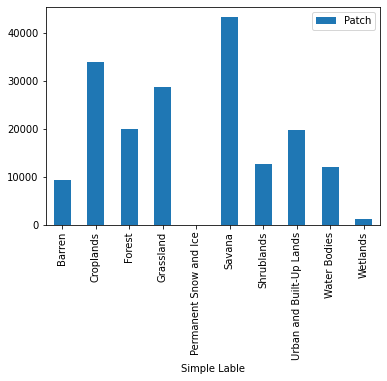

In [18]:
df_slabel.plot(y='Patch',kind='bar')

<AxesSubplot:xlabel='Full Lable'>

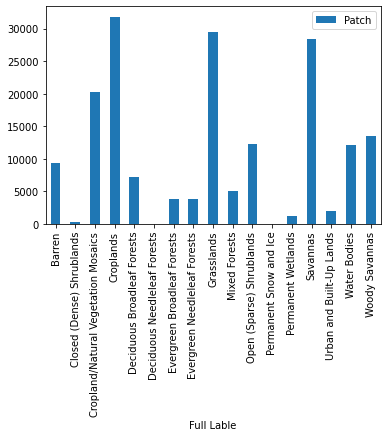

In [19]:
df_flabel.plot(y='Patch',kind='bar')

## Group by Region

(125, 2)

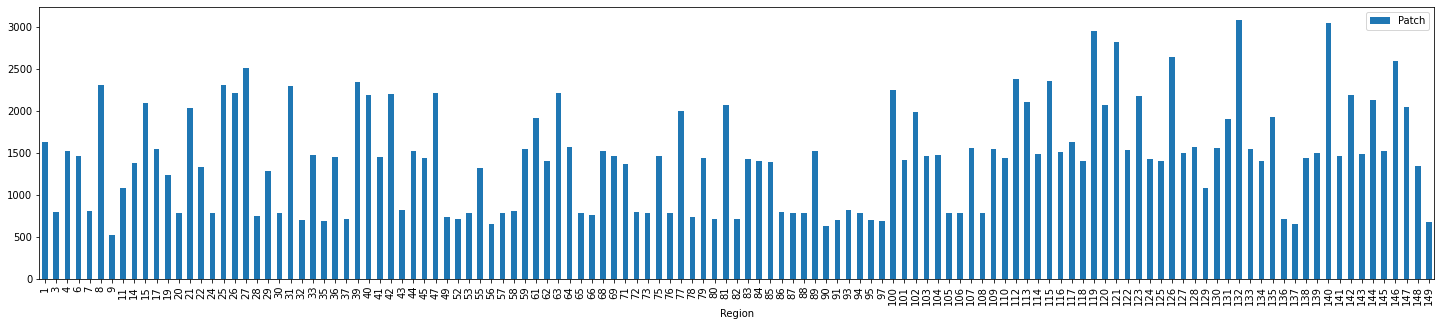

In [20]:
df_region = dfinal[['region','Patch']].groupby('region').count()
df_region = df_region.reset_index()
df_region['Region'] = df_region['region'].map(lambda x: int(x)) 
df_region.set_index('Region', inplace=True)
df_region.sort_index(inplace=True)
df_region.head()
df_region.plot(y='Patch',kind='bar',figsize=(25,5))
df_region.shape

### Group By Season

<AxesSubplot:xlabel='season'>

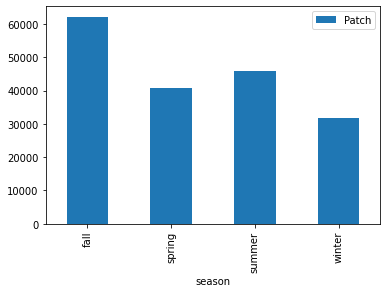

In [21]:
df_season = dfinal[['season','Patch']].groupby('season').count()
df_season.plot(y='Patch',kind='bar')

## Ploting images

In [168]:
def plot_image(img_path):
    imf = rasterio.open(img_path)

    print(imf.meta)
    print(imf.bounds)
    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
#     trafo = imf.transform
#     crs = imf.crs
#     x = trafo[2]
#     y = trafo[5]
    
#     inProj = Proj(init=crs)
#     outProj = Proj(init='epsg:4326')
#     x,y = transform(inProj,outProj,x,y)
#     print(x,y)
#     print('Image Size: ',image_array.shape)
    ni = image_array.shape[0]
    fig = plt.figure(figsize=(15,10))

    for i in range(ni):
        plt.subplots_adjust(hspace=.1)
        plt.subplot(1,ni,i+1)
        plt.imshow(image_array[i],interpolation='nearest',cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.title('Band '+str(i+1), fontsize=14)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 256, 'height': 256, 'count': 13, 'crs': CRS.from_epsg(32737), 'transform': Affine(10.0, 0.0, 404852.3389928384,
       0.0, -10.0, 8103942.836060452)}
BoundingBox(left=404852.3389928384, bottom=8101382.836060452, right=407412.3389928384, top=8103942.836060452)


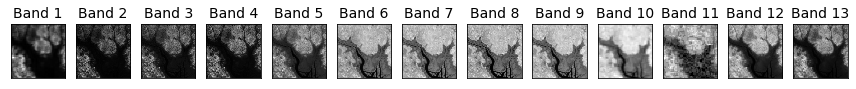

In [181]:
# /storage/sen12ms_x/ROIs1158_spring/s1_1/ROIs1158_spring_s1_1_p343.tif
# /storage/sen12ms_x/ROIs1970_fall/s1_1/ROIs1970_fall_s1_1_p761.tif

img_path = root+'/ROIs1158_spring/s2_1/ROIs1158_spring_s2_1_p343.tif'
plot_image(img_path)
# img_path = root+'/ROIs1970_fall/s2_1/ROIs1970_fall_s2_1_p761.tif'
# plot_image(img_path)
# img_path =  root+'/ROIs2017_winter/lc_55/ROIs2017_winter_s2_55_p425.tif'
# plot_image(img_path)

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 256, 'height': 256, 'count': 4, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': None, 'width': 256, 'height': 256, 'count': 2, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 391638.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=391638.4708795169, bottom=5889240.150648338, right=394198.4708795169, top=5891800.150648338)
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 256, 'height': 256, 'count': 13, 'crs': CRS.from_epsg(32719), 'transform': Affine(10.0, 0.0, 390358.4708795169,
       0.0, -10.0, 5891800.150648338)}
BoundingBox(left=390358.4708795169, bottom=5889240.150648338, right=392918.4708795169, top=5891800.150648338)


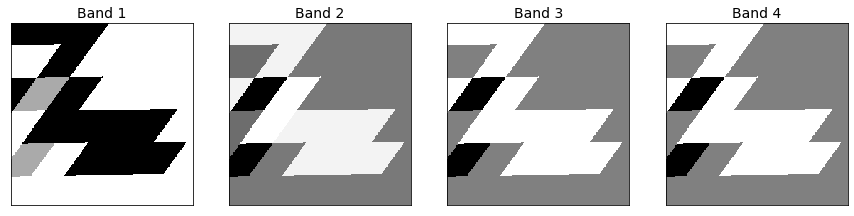

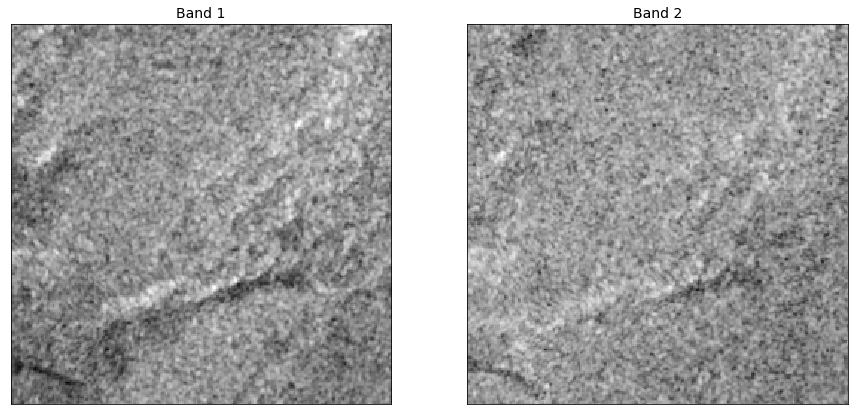

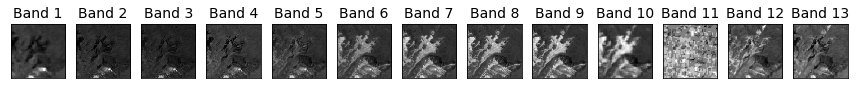

In [23]:
img_path = root+'/ROIs2017_winter/lc_55/ROIs2017_winter_lc_55_p426.tif'
plot_image(img_path)
img_path = root+'/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p426.tif'
plot_image(img_path)
img_path =  root+'/ROIs2017_winter/s2_55/ROIs2017_winter_s2_55_p425.tif'
plot_image(img_path)

## Closest Distance

In this section, a data frame and a .csv file (distance_min_pair.csv) is created with the path of a pair of files that have the closest patches with respect to the same season (including the same season). The trivial solution (the patch itself) is excluded. The idea of this information is to explore possible overlaps between images in the seme season or any other.

Note: This section may take a couple of hours to be completed. If the file distance_min_pair.csv is available, it can be loaded

In [147]:
# Calculating the distance between two points with their coordinates
import math as m
def distance(c1,c0):
    """
    This function calculate the distance between 2 geographical locations
    c1: is a tuple (latitude_1, longitude_1)
    c0: is a tuple (latitude_0, longitude_0)   
    """
    r = 6371.0 # in km
    lat1 = c1[0]
    lon1 = c1[1]
    lat0 = c0[0]
    lon0 = c0[1]
    lat0 = float(lat0)*m.pi/180.0
    lon0 = float(lon0)*m.pi/180.0
    lat1 = float(lat1)*m.pi/180.0
    lon1 = float(lon1)*m.pi/180.0
  
    a = m.sin(0.5*(lat1-lat0))**2 + m.cos(lat0)*m.cos(lat1)*m.sin(0.5*(lon1-lon0))**2
    c = 2.0*m.atan2(m.sqrt(a),m.sqrt(1-a))

    return r*c

In [148]:
def get_xy(img_path):
    """
    This function extract the geographic coordinates from a Gtiff file
    img_path: is the path to the GeoTiff file
    """
    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    
    return y,x

In [149]:
clpair_dic={'region':[],
            'distance':[],
            'file 1': [],
            'file 2': [],
            'season 1': [],
            'season 2': []
           }
df_clpair = pd.DataFrame(clpair_dic) 
seasons_list = ['fall','spring','summer','winter']
regions_list = tiles['region'].unique()
regions_list.sort()
regions_list

array(['1', '100', '101', '102', '103', '104', '105', '106', '107', '108',
       '109', '11', '110', '112', '113', '114', '115', '116', '117',
       '118', '119', '120', '121', '122', '123', '124', '125', '126',
       '127', '128', '129', '130', '131', '132', '133', '134', '135',
       '136', '137', '138', '139', '14', '140', '141', '142', '143',
       '144', '145', '146', '147', '148', '149', '15', '17', '19', '20',
       '21', '22', '24', '25', '26', '27', '28', '29', '3', '30', '31',
       '32', '33', '35', '36', '37', '39', '4', '40', '41', '42', '43',
       '44', '45', '47', '49', '52', '53', '55', '56', '57', '58', '59',
       '6', '61', '62', '63', '64', '65', '66', '68', '69', '7', '71',
       '72', '73', '75', '76', '77', '78', '79', '8', '80', '81', '82',
       '83', '84', '85', '86', '87', '88', '89', '9', '90', '91', '93',
       '94', '95', '97'], dtype=object)

In [159]:
for rid in regions_list:
    print('Writing Region: {}'.format(rid))
    region_select = tiles[(tiles['region'] == rid) & (tiles['sensor'] == 's1')]
    xy = region_select["path"].map(get_xy)
    region_select['xy']=xy

    df_dict = {}
    df_dict['fall'] = region_select[region_select.season == 'fall']
    df_dict['spring'] = region_select[region_select.season == 'spring']
    df_dict['summer'] = region_select[region_select.season == 'summer']
    df_dict['winter'] = region_select[region_select.season == 'winter']

    for i in region_select.index:
        xo = region_select['xy'][i][1]
        yo = region_select['xy'][i][0]
        ss = region_select['season'][i]
        print(xo,yo,ss)
        for season_idx in seasons_list:
            if df_dict[season_idx].size == 0:
                continue
            xyd = []
            for j in df_dict[season_idx].index:
                if i==j:
                    xyd.append(9.99999990e+20)
                else:
                    xyd.append(distance(df_dict[season_idx]['xy'][j],(yo,xo)))
            xyd2 = np.array(xyd)
            jj = df_dict[season_idx].index[xyd2.argmin()]
            df_clpair.loc[len(df_clpair.index)] = [rid,xyd2.min(),
                                                   region_select['path'][i],
                                                   df_dict[season_idx]['path'][jj],
                                                   ss,season_idx
                                                  ]

    df_clpair.to_csv('/scratch/crguest/SEN12MS/utils/close_patches/distance_min_pair_region_'+rid+'_v2.csv')
    df_clpair = df_clpair.iloc[0:0]

Writing Region: 1


In [175]:
print(region_select['path'][428947])
print(region_select['path'][11143])

/storage/sen12ms_x/ROIs1158_spring/s1_1/ROIs1158_spring_s1_1_p343.tif
/storage/sen12ms_x/ROIs1970_fall/s1_1/ROIs1970_fall_s1_1_p761.tif


## Read CSV

### Do patches acquired in different sessions overlap?

In [114]:
dist_clt_list = os.listdir('/scratch/crguest/SEN12MS/utils/close_patches')

dist = 2.5
for filein in dist_clt_list:
    dfcurr = pd.read_csv('/scratch/crguest/SEN12MS/utils/close_patches/'+filein)
    dfcurr.rename(columns={"season 1": "season1", "season 2": "season2"}, inplace=True)
    
    if cont == 0:
        short_distance = dfcurr[(dfcurr.season1 != dfcurr.season2) & (dfcurr.distance < dist)].copy()
    else:
        short_distance.append(dfcurr[(dfcurr.season1 != dfcurr.season2) & (dfcurr.distance < dist)])
    cont=+1

print('There are {} patches overlaping'.format(short_distance.shape[0]))

if short_distance.shape[0] > 0:
    short_distance.head()

There are 0 patches overlaping


### What is the minimum distance between patches in each region

In [140]:
dist_clt_list = os.listdir('/scratch/crguest/SEN12MS/utils/close_patches')

dis_dict = {}
for filein in dist_clt_list:
    dfcurr = pd.read_csv('/scratch/crguest/SEN12MS/utils/close_patches/'+filein)
    dfcurr.reset_index(inplace=True)
    dfcurr.rename(columns={"season 1": "season1", "season 2": "season2"}, inplace=True)
    region = int(dfcurr['region'].unique()[0]) 
    dfcurr = dfcurr[dfcurr.season1 != dfcurr.season2]
     
    if dfcurr.shape[0] == 0:
        dis_dict[region] = None
    else:
        dis_dict[region] = dfcurr['distance'].to_numpy().min()

In [193]:
region_id = []
distance = []
single_season = []
for item in dis_dict.items():
    if item[1] == None:
        single_season.append(item[0])
    else:
        region_id.append(item[0])
        distance.append(item[1])
    

In [199]:
# Single sessions regions
print('There are {} regions with single sessions: \n {}'.format(len(single_season),np.array(single_season)))

There are 39 regions with single sessions: 
 [ 73  91  57  66  94  37 137  35  78  88  82  43  24  86  56  58  72 149
  76   7  95   3 136  90  49 105 108  28  97  30  20  52  65  53   9  87
  80  32 106]


Text(0, 0.5, 'Distance (Km)')

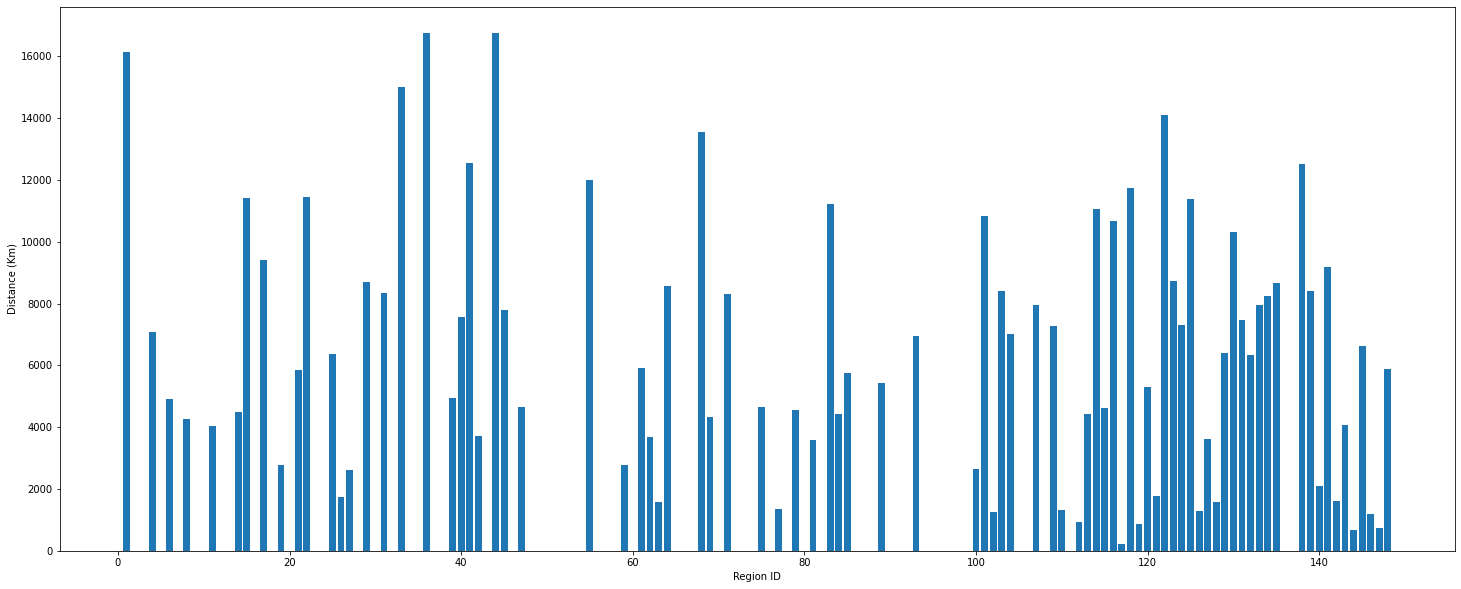

In [211]:
plt.figure(figsize=(25,10))
plt.bar(region_id,distance)
plt.xlabel('Region ID')
plt.ylabel('Distance (Km)')

In [210]:
print('Shortest distance between paths from different seasons')
print(region_id[np.array(distance).argmin()],np.array(distance).min())

117 205.0355625050295


## Grouping by UTM Zones

In [ ]:
def get_zone(img_path):
    """
    This function extract the geographic coordinates from a Gtiff file
    img_path: is the path to the GeoTiff file
    """
    imf = rasterio.open(img_path)

    image_sequence = imf.read()
    image_array = np.array(image_sequence)
    
    trafo = imf.transform
    crs = imf.crs
    x = trafo[2]
    y = trafo[5]
    
    inProj = Proj(init=crs)
    outProj = Proj(init='epsg:4326')
    x,y = transform(inProj,outProj,x,y)
    
    return y,x

In [217]:
all_patch = tiles[(tiles['sensor'] == 's1')]
all_patch.head()

,path,seed,season,sensor,region,tile
0,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p404.tif
1,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p798.tif
2,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p810.tif
3,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p186.tif
4,/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs19...,ROIs1970,fall,s1,149,p510.tif


In [218]:
test_path = '/storage/sen12ms_x/ROIs1970_fall/s1_149/ROIs1970_fall_s1_149_p404.tif'
imf = rasterio.open(test_path)
imf.meta

{'driver': 'GTiff',
 'dtype': 'float32',
 'nodata': None,
 'width': 256,
 'height': 256,
 'count': 2,
 'crs': CRS.from_epsg(32631),
 'transform': Affine(10.0, 0.0, 449191.3963381321,
        0.0, -10.0, 4880468.455379836)}

In [231]:
phrase = imf.crs.wkt
phrase2 = phrase.split(',')[0]
idx = phrase2.index('UTM zone')
phrase2[idx+9:-1]


'31N'

In [190]:
dftest = pd.read_csv('/scratch/crguest/SEN12MS/utils/close_patches/distance_min_pair_region_39.csv')
dftest['season 2'].unique()

array(['fall', 'spring', 'winter'], dtype=object)

In [74]:
from matplotlib.patches import Rectangle

def only_bounds(img_path):
    imf = rasterio.open(img_path)
    return imf.bounds

(5887240.150648338, 5893800.150648338)

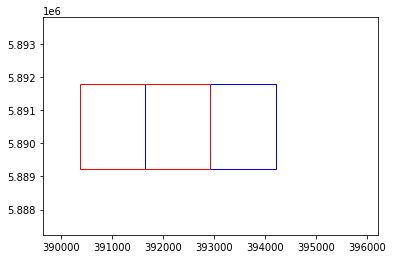

In [109]:
img_path1 = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p426.tif'
img_path2 = '/workspace/app/data/sen12ms/ROIs2017_winter/s1_55/ROIs2017_winter_s1_55_p425.tif'
p1 = only_bounds(img_path1)
p2 = only_bounds(img_path2)

fig, ax = plt.subplots()

ax.add_patch(Rectangle((p1.left, p1.top), p1.right-p1.left, p1.bottom-p1.top,fill=False,edgecolor = 'blue'))
ax.add_patch(Rectangle((p2.left, p2.top), p2.right-p2.left, p2.bottom-p2.top,fill=False,edgecolor = 'red'))

ax.set_xlim([p1.left-2000,p1.right+2000])
ax.set_ylim([p1.bottom-2000,p1.top+2000])